In [50]:
import copy, copy, click, imageio, dnnlib, legacy, secrets, pickle
from time import perf_counter

import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
# start screen
# start srun session
# activate the stylegan2pt environment
# *before* you run your jupyter, run these commands in the terminal:
!gcc --version
!nvcc -V
# then launch your jupyter and detach from screen

gcc (roman-koshkin-saion-intel01) 7.1.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [3]:
!pwd

/home/r/roman-koshkin/stylegan2-ada-pytorch


In [ ]:
# face aligner (if you need to detect faces in a bunch of files and align them automatically)
# if something doesn't work (check out the Toonify environment for missing packages or go to
# https://github.com/justinpinkney/stylegan2 or
# the colab notebook at https://colab.research.google.com/drive/1XaseXqiNhRdPMzY5uI9SVf9W8hVrZRdd#scrollTo=cuMEHnpmI1Mj)

!python align_images.py raw_aliens aligned_aliens

In [7]:
# the legacy.load_network_pkl function downloads models from the internet, but can also load files from a local path
# all the big files are on /bucket/FukaiU/Roman/DATA_AND_BIG_FILES/

# If you use network download, once downloaded, the model is cached in /home/roman/.cache/dnnlib/downloads

# network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'
network_pkl = '/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq_stylegan2_ada_pytorch.pkl'

device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)

In [5]:
# if necessary, you can use legacy.pyp to convert TF pickles to Torch pickles.
# here I convert a blended model:
# (hybrid of of StyleGAN2 trained on FFHQ with StyleGAN2 trained on FFHQ and then finetuned on Pixar)

# !python legacy.py --source=/home/roman/Downloads/ffhq-cartoon-blended-64.pkl --dest=./ffhq-cartoon-blended-64_torch.pkl

Loading "/home/roman/Downloads/ffhq-cartoon-blended-64.pkl"...
Saving "./ffhq-cartoon-blended-64_torch.pkl"...
Done.


In [73]:
!python projector.py --help

Usage: projector.py [OPTIONS]

  Project given image to the latent space of pretrained network pickle.

  Examples:

  python projector.py --outdir=out --target=~/mytargetimg.png \
      --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

Options:
  --network TEXT        Network pickle filename  [required]
  --target FILE         Target image file to project to  [required]
  --num-steps INTEGER   Number of optimization steps  [default: 1000]
  --seed INTEGER        Random seed  [default: 303]
  --save-video BOOLEAN  Save an mp4 video of optimization progress  [default:
                        True]

  --outdir DIR          Where to save the output images  [required]
  --help                Show this message and exit.


In [10]:
# now optimize the latent vector (i.e. project the target image into the latent space)
# 1) if you just use the model trained on the FFHQ, you'll get a latent vector
# that, when run through the network, corresponds to the target image as closely as possible
# 2) then you run this latent vector throught the FFHQ/Pixar hybrid model. You'll get an 
# image that is as close to the target image as possible, but the image will bear features 
# characteristic of a Pixar character!


# 1) get the latent vector:
!python ./projector.py --outdir=out \
--target=./aligned/девочка1_01.png \
--network=/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq_stylegan2_ada_pytorch.pkl \
--num-steps=200 \
--save-video=False

# after the process is done, you also get a nice movie of the optimization process

Loading networks from "/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq_stylegan2_ada_pytorch.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/200: dist 0.65 loss 24567.21
step    2/200: dist 0.69 loss 27640.59
step    3/200: dist 0.65 loss 25430.29
step    4/200: dist 0.62 loss 21590.14
step    5/200: dist 0.58 loss 16999.52
step    6/200: dist 0.51 loss 12123.97
step    7/200: dist 0.58 loss 7907.34
step    8/200: dist 0.61 loss 4635.40
step    9/200: dist 0.62 loss 3092.94
step   10/200: dist 0.48 loss 3340.11
step   11/200: dist 0.55 loss 4930.39
step   12/200: dist 0.55 loss 6639.00
step   13/200: dist 0.53 loss 7758.43
step   14/200: dist 0.50 loss 7780.94
step   15/200: dist 0.50 loss 7019.69
step   16/200: dist 0.48 loss 5730.51
step   17/200: dist 0.51 loss 4315.70
step   18/200: dist 0.45 loss 3170.78
step   19/200: dist 0.45 loss 2329.18
step   20/20

In [12]:
!python generate.py \
--outdir=out \
--projected_w=out/projected_w.npz \
--network=/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq-cartoon-blended-64_torch.pkl

Usage: generate2.py [OPTIONS]
Try 'generate2.py --help' for help.

Error: no such option: --projected_w


In [4]:
# !source $HOME/opt/gcc-7.1.0/activate

noise_mode = 'const'
target = './aligned/девочка1_01.png'

ws = np.load('./out/projected_w.npz')['w']
ws = torch.tensor(ws, device='cuda') # pylint: disable=not-callable

with open('/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq_stylegan2_ada_pytorch.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
with open('/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq-cartoon-blended-64_torch.pkl', 'rb') as f:
    G_hybrid = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
# G_hybrid = torch.load('tmp.pkl').cuda()
    
for idx, w in enumerate(ws):
    img = G.synthesis(w.unsqueeze(0), noise_mode=noise_mode)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img = img[0].cpu().numpy()
    img1 = G_hybrid.synthesis(w.unsqueeze(0), noise_mode=noise_mode)
    img1 = (img1.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img1 = img1[0].cpu().numpy()
    

im = imageio.imread(target)

IMG = np.concatenate([im, img, img1], axis=1)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


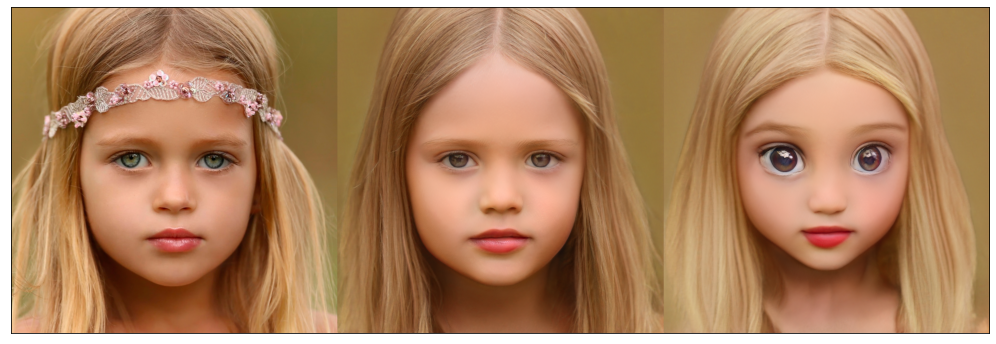

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(19,6))
plt.imshow(IMG)
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)

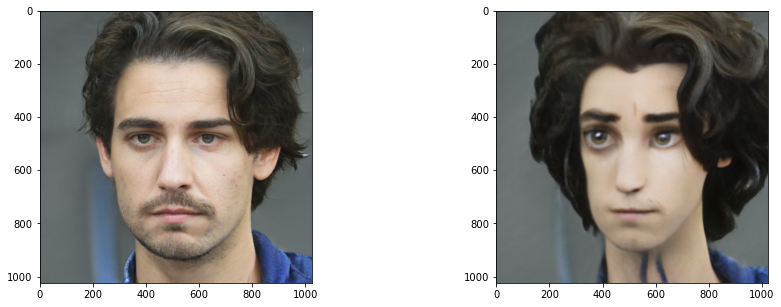

In [6]:
# generate images in the pixel space by forwarding the same point in the latent space of 
# two versions of StyleGAN2 (the original (trained on FFHQ and the same one but fine-tuned on Pixar))

z = torch.randn([1, G.z_dim]).cuda()    # latent codes

fig, ax = plt.subplots(1,2, figsize=(15,5))
with open('/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq_stylegan2_ada_pytorch.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
c = None                                # class labels (not used in this example)
img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]
img = img.squeeze().cpu().detach().numpy().transpose(1,2,0)
img += 1
img /= img.max()
ax[0].imshow(img)

with open('/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq-cartoon-blended-64_torch.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
# z = torch.randn([1, G.z_dim]).cuda()    # latent codes
c = None                                # class labels (not used in this example)
img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]
img = img.squeeze().cpu().detach().numpy().transpose(1,2,0)
img += 1
img /= img.max()
ax[1].imshow(img)

In [7]:
!python align_images.py asdf aligned_ds

^C


In [59]:
!nvidia-smi

Mon Nov 29 10:31:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   43C    P0    43W / 300W |   1835MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [1]:
# # open a terminal and enter
# !source $HOME/opt/gcc-7.1.0/activate

In [9]:
# fine-tune the FFHQ-trained StyleGAN2 on our small dataset:
!python train.py \
    --outdir=./training-runs_aliens \
    --data=./aligned_aliens \
    --gpus=4 --cfg=auto \
    --resume=/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq_stylegan2_ada_pytorch.pkl \
    --snap=10 \
    --aug=ada


Training options:
{
  "num_gpus": 4,
  "image_snapshot_ticks": 10,
  "network_snapshot_ticks": 10,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "./aligned_aliens",
    "use_labels": false,
    "max_size": 194,
    "xflip": false,
    "resolution": 1024
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 32768,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "channel_max": 512,
    "

Distributing across 4 GPUs...
Setting up training phases...
Exporting sample images...
Initializing logs...
Skipping tfevents export: No module named 'tensorboard'
Training for 25000 kimg...

tick 0     kimg 0.0      time 41s          sec/tick 9.7     sec/kimg 608.95  maintenance 31.0   cpumem 3.55   gpumem 12.34  augment 0.000
Evaluating metrics...
{"results": {"fid50k_full": 167.42879318665268}, "metric": "fid50k_full", "total_time": 541.0704257488251, "total_time_str": "9m 01s", "num_gpus": 4, "snapshot_pkl": "network-snapshot-000000.pkl", "timestamp": 1638152387.3669279}
tick 1     kimg 4.0      time 17m 40s      sec/tick 461.9   sec/kimg 115.48  maintenance 556.9  cpumem 3.92   gpumem 7.70   augment 0.034
tick 2     kimg 8.0      time 25m 24s      sec/tick 463.8   sec/kimg 115.95  maintenance 0.3    cpumem 3.92   gpumem 7.71   augment 0.069
tick 3     kimg 12.0     time 33m 07s      sec/tick 462.7   sec/kimg 115.68  maintenance 0.3    cpumem 3.92   gpumem 7.76   augment 0.058
tick

In [ ]:
# portraits dataset
!python train.py --outdir=./training-runs-portraits --data=./aligned_portraits --gpus=4 --cfg=auto --resume=./ffhq_stylegan2_ada_pytorch.pkl --snap=10 --aug=ada


Training options:
{
  "num_gpus": 4,
  "image_snapshot_ticks": 10,
  "network_snapshot_ticks": 10,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "./aligned_portraits",
    "use_labels": false,
    "max_size": 110,
    "xflip": false,
    "resolution": 1024
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 32768,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "channel_max": 512,
  

Distributing across 4 GPUs...
Setting up training phases...
Exporting sample images...
Initializing logs...
Skipping tfevents export: No module named 'tensorboard'
Training for 25000 kimg...

tick 0     kimg 0.0      time 43s          sec/tick 9.7     sec/kimg 604.31  maintenance 33.1   cpumem 3.56   gpumem 12.34  augment 0.000
Evaluating metrics...


In [ ]:
ls training-runs_aliens/00002-aligned_aliens-auto4-ada-resumecustom/network-snapshot-000000.pkl

In [10]:
2+2

4

In [19]:
# swap some layers

import pickle

def blend(res):
    print(res)
    with open('/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq_stylegan2_ada_pytorch.pkl', 'rb') as f:
        G_1 = pickle.load(f)['G_ema']
    
    # for the Metfaces dataset:
    # with open('metfaces.pkl', 'rb') as f:
    #     G_2 = pickle.load(f)['G_ema']
    
    # for the first dataset:
    with open('training-runs_aliens/00000-aligned_aliens-auto4-ada-resumecustom/network-snapshot-000040.pkl', 'rb') as f:
        G_2 = pickle.load(f)['G_ema']

    with open('/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq_stylegan2_ada_pytorch.pkl', 'rb') as f:
        tmp = pickle.load(f)['G_ema']


    state_dict1 = G_1.state_dict()
    state_dict2 = G_2.state_dict()

    with torch.no_grad():
        for name, param in state_dict1.items():
            if ('conv' in name) | ('torgb' in name):
                if int(name.split('.')[1][1:]) in res:
                    state_dict1[name] = state_dict2[name]
                    print(name)

    tmp.load_state_dict(state_dict1)
    torch.save(tmp, 'tmp.pkl')

In [18]:
# now optimize the latent vector (i.e. project the target image into the latent space)
# 1) if you just use the model trained on the FFHQ, you'll get a latent vector
# that, when run through the network, corresponds to the target image as closely as possible
# 2) then you run this latent vector throught the FFHQ/Pixar hybrid model. You'll get an 
# image that is as close to the target image as possible, but the image will bear features 
# characteristic of a Pixar character!


!source $HOME/opt/gcc-7.1.0/activate

# 1) get the latent vector:
!python ./projector.py --outdir=out \
--target=./aligned/девочка2_01.png \
--network=/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq_stylegan2_ada_pytorch.pkl \
--num-steps=300 \
--save-video=False

Loading networks from "/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq_stylegan2_ada_pytorch.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/300: dist 0.67 loss 24567.22
step    2/300: dist 0.66 loss 27640.56
step    3/300: dist 0.68 loss 26123.31
step    4/300: dist 0.65 loss 23383.82
step    5/300: dist 0.64 loss 19904.32
step    6/300: dist 0.65 loss 15971.43
step    7/300: dist 0.62 loss 12054.15
step    8/300: dist 0.60 loss 8433.42
step    9/300: dist 0.64 loss 5479.15
step   10/300: dist 0.59 loss 3436.38
step   11/300: dist 0.63 loss 2630.36
step   12/300: dist 0.60 loss 2909.69
step   13/300: dist 0.55 loss 3874.26
step   14/300: dist 0.50 loss 5083.35
step   15/300: dist 0.52 loss 6091.17
step   16/300: dist 0.51 loss 6503.57
step   17/300: dist 0.52 loss 6231.27
step   18/300: dist 0.49 loss 5420.85
step   19/300: dist 0.54 loss 4377.12
step   20/3

step  219/300: dist 0.36 loss 4.31 
step  220/300: dist 0.36 loss 4.20 
step  221/300: dist 0.36 loss 10.23
step  222/300: dist 0.36 loss 10.74
step  223/300: dist 0.36 loss 4.07 
step  224/300: dist 0.36 loss 1.33 
step  225/300: dist 0.36 loss 6.10 
step  226/300: dist 0.36 loss 8.22 
step  227/300: dist 0.36 loss 3.82 
step  228/300: dist 0.36 loss 2.03 
step  229/300: dist 0.36 loss 6.31 
step  230/300: dist 0.37 loss 9.20 
step  231/300: dist 0.36 loss 7.09 
step  232/300: dist 0.36 loss 3.88 
step  233/300: dist 0.36 loss 2.59 
step  234/300: dist 0.37 loss 3.08 
step  235/300: dist 0.36 loss 4.15 
step  236/300: dist 0.36 loss 3.42 
step  237/300: dist 0.36 loss 1.42 
step  238/300: dist 0.36 loss 1.92 
step  239/300: dist 0.36 loss 3.06 
step  240/300: dist 0.36 loss 1.47 
step  241/300: dist 0.36 loss 0.94 
step  242/300: dist 0.36 loss 2.18 
step  243/300: dist 0.36 loss 1.23 
step  244/300: dist 0.36 loss 0.73 
step  245/300: dist 0.36 loss 1.60 
step  246/300: dist 0.36 los

[4, 8, 16, 32, 64, 128, 256]
[]
[4]
synthesis.b4.conv1.weight
synthesis.b4.conv1.noise_strength
synthesis.b4.conv1.bias
synthesis.b4.conv1.resample_filter
synthesis.b4.conv1.noise_const
synthesis.b4.conv1.affine.weight
synthesis.b4.conv1.affine.bias
synthesis.b4.torgb.weight
synthesis.b4.torgb.bias
synthesis.b4.torgb.affine.weight
synthesis.b4.torgb.affine.bias
[4, 8]
synthesis.b4.conv1.weight
synthesis.b4.conv1.noise_strength
synthesis.b4.conv1.bias
synthesis.b4.conv1.resample_filter
synthesis.b4.conv1.noise_const
synthesis.b4.conv1.affine.weight
synthesis.b4.conv1.affine.bias
synthesis.b4.torgb.weight
synthesis.b4.torgb.bias
synthesis.b4.torgb.affine.weight
synthesis.b4.torgb.affine.bias
synthesis.b8.conv0.weight
synthesis.b8.conv0.noise_strength
synthesis.b8.conv0.bias
synthesis.b8.conv0.resample_filter
synthesis.b8.conv0.noise_const
synthesis.b8.conv0.affine.weight
synthesis.b8.conv0.affine.bias
synthesis.b8.conv1.weight
synthesis.b8.conv1.noise_strength
synthesis.b8.conv1.bias
syn

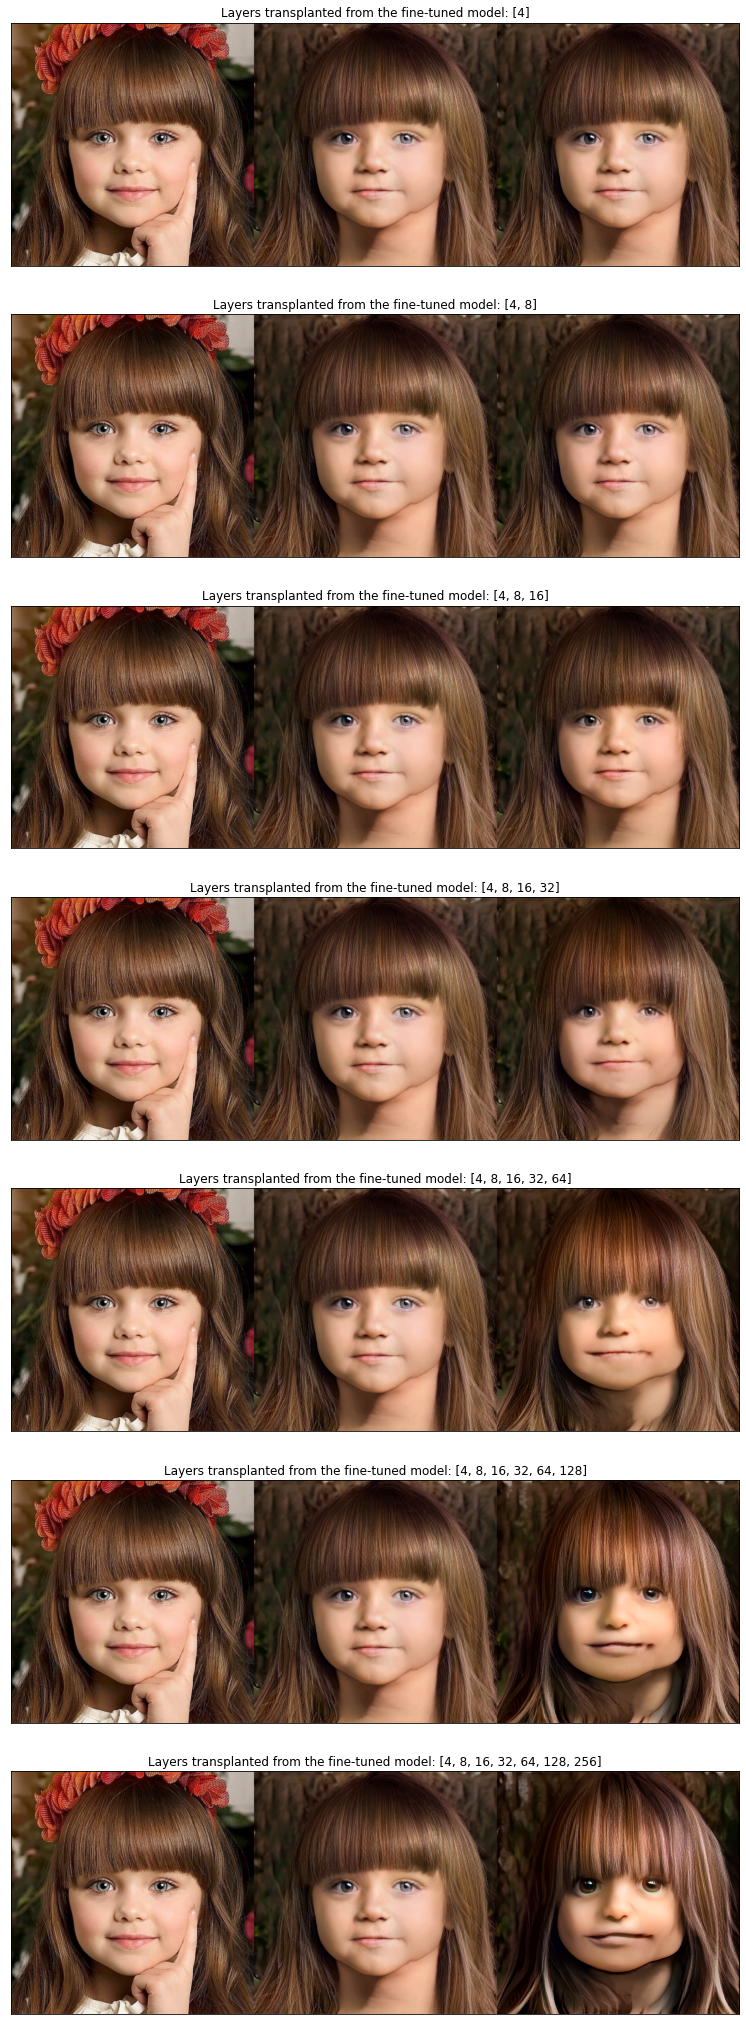

In [21]:
# res = list(reversed([4, 8, 16, 32, 64, 128, 256]))
res = [4, 8, 16, 32, 64, 128, 256]
print(res)

plt.figure(figsize=(19,6*len(res)))

for r in range(len(res)):
    
    blend(res[:r])
    
    noise_mode = 'const'
    target = './aligned/девочка2_01.png'

    ws = np.load('./out/projected_w.npz')['w']
    ws = torch.tensor(ws, device='cuda') # pylint: disable=not-callable

    with open('/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq_stylegan2_ada_pytorch.pkl', 'rb') as f:
        G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
#     with open('/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq-cartoon-blended-64_torch.pkl', 'rb') as f:
#         G_hybrid = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
    G_hybrid = torch.load('tmp.pkl').cuda()
#     os.system(f'rm {"tmp.pkl"}')
    

    for idx, w in enumerate(ws):
        img = G.synthesis(w.unsqueeze(0), noise_mode=noise_mode)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        img = img[0].cpu().numpy()
        img1 = G_hybrid.synthesis(w.unsqueeze(0), noise_mode=noise_mode)
        img1 = (img1.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        img1 = img1[0].cpu().numpy()
    im = imageio.imread(target)
    IMG = np.concatenate([im, img, img1], axis=1)

    plt.subplot(len(res)+1, 1, r+1)
    plt.imshow(IMG)
    plt.gca().yaxis.set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.title(f'Layers transplanted from the fine-tuned model: {res[:r+1]}')

In [61]:

def generate_pics():
    # generate images in the pixel space by forwarding the same point in the latent space of 
    # two versions of StyleGAN2 (the original (trained on FFHQ and the same one but fine-tuned on Pixar))

    z = torch.randn([1, 512]).cuda()    # random latent code

    # z = np.load('./out/projected_w.npz')['w']
    # z = torch.tensor(z, device='cuda') # a code for the real StyleGAN2
    # z = z[0,17,:].reshape(1, -1)

    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    with open('/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq_stylegan2_ada_pytorch.pkl', 'rb') as f:
        G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
    c = None                                # class labels (not used in this example)
    img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]
    img = img.squeeze().cpu().detach().numpy().transpose(1,2,0)
    img += 1
    img /= img.max()
    img0 = img.copy()


    with open('/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq-cartoon-blended-64_torch.pkl', 'rb') as f:
        G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
    # z = torch.randn([1, G.z_dim]).cuda()    # latent codes
    c = None                                # class labels (not used in this example)
    img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]
    img = img.squeeze().cpu().detach().numpy().transpose(1,2,0)
    img += 1
    img /= img.max()
    img1 = img.copy()


    # with open('/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ffhq-cartoon-blended-64_torch.pkl', 'rb') as f:
    G = torch.load('tmp.pkl').cuda()  # torch.nn.Module
    # z = torch.randn([1, G.z_dim]).cuda()    # latent codes
    c = None                                # class labels (not used in this example)
    img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]
    img = img.squeeze().cpu().detach().numpy().transpose(1,2,0)
    img += 1
    img /= img.max()
    img2 = img.copy()

    IMG = np.concatenate([img0, img1, img2], axis=1)
    ax.imshow(np.clip(IMG, a_min=0.0, a_max=1.0))
    plt.savefig(f'img_{secrets.token_hex(nbytes=16)}.png', dpi=400)
    plt.close('all')

              

for i in trange(10):
    generate_pics()

!tar -czvf pics.tar.gz img_*
!ls | grep "img_" | xargs rm -r

100%|██████████| 10/10 [00:43<00:00,  4.35s/it]

img_070905e7c0bcdefadad8b98e63ad1838.png


img_3f6870a1b9ae87b5b09c641532d15447.png
img_58b317f588dbc7e10587c3812b60abe8.png
img_6647f7ad3c9c06c57448d8eef361c8d9.png
img_6773a9e6557dec2530f6606c1fade7ef.png
img_6a22d056b24854488c253792af80b9ea.png
img_91f831f3a1b7b4adae074c0f8109f5b8.png
img_977a0dc23c8b0a871492bd37bdae36a5.png
img_a5c58a62bb8368498af83ed228233851.png
img_abdc7106886fa3fd046e53cbae825d27.png


In [15]:
# PERFORM INTERPOLATIONS:

# https://github.com/dvschultz/stylegan2-ada-pytorch
# the generate2.py is from a different repo

!python generate2.py    --outdir=video1-w-0.5 \
                        --space="z" \
                        --trunc=0.6 \
                        --process="interpolation" \
                        --seeds=463,470,500,700,85,265,297,849,131,121,101,554 \
                        --network=tmp.pkl

! tar -czvf frames1.tar.gz video1-w-0.5/
! rm -r video1-w-0.5/

video1-w-0.5/
video1-w-0.5/frames/
video1-w-0.5/frames/frame0223.png
video1-w-0.5/frames/frame1513.png
video1-w-0.5/frames/frame2611.png
video1-w-0.5/frames/frame1893.png
video1-w-0.5/frames/frame1318.png
video1-w-0.5/frames/frame2563.png
video1-w-0.5/frames/frame1543.png
video1-w-0.5/frames/frame1409.png
video1-w-0.5/frames/frame1747.png
video1-w-0.5/frames/frame2443.png
video1-w-0.5/frames/frame1026.png
video1-w-0.5/frames/frame0844.png
video1-w-0.5/frames/frame1356.png
video1-w-0.5/frames/frame2447.png
video1-w-0.5/frames/frame0404.png
video1-w-0.5/frames/frame2303.png
video1-w-0.5/frames/frame1418.png
video1-w-0.5/frames/frame1268.png
video1-w-0.5/frames/frame2507.png
video1-w-0.5/frames/frame0576.png
video1-w-0.5/frames/frame0039.png
video1-w-0.5/frames/frame1589.png
video1-w-0.5/frames/frame0437.png
video1-w-0.5/frames/frame2057.png
video1-w-0.5/frames/frame2156.png
video1-w-0.5/frames/frame0653.png
video1-w-0.5/frames/frame2429.png
video1-w-0.5/frames/frame0436.png
video1-w-0.5/

video1-w-0.5/frames/frame2444.png
video1-w-0.5/frames/frame1546.png
video1-w-0.5/frames/frame2630.png
video1-w-0.5/frames/frame1277.png
video1-w-0.5/frames/frame0410.png
video1-w-0.5/frames/frame1702.png
video1-w-0.5/frames/frame0259.png
video1-w-0.5/frames/frame0920.png
video1-w-0.5/frames/frame1507.png
video1-w-0.5/frames/frame0491.png
video1-w-0.5/frames/frame0476.png
video1-w-0.5/frames/frame1183.png
video1-w-0.5/frames/frame0451.png
video1-w-0.5/frames/frame1941.png
video1-w-0.5/frames/frame1089.png
video1-w-0.5/frames/frame2026.png
video1-w-0.5/frames/frame2631.png
video1-w-0.5/frames/frame1079.png
video1-w-0.5/frames/frame1427.png
video1-w-0.5/frames/frame1424.png
video1-w-0.5/frames/frame0137.png
video1-w-0.5/frames/frame0712.png
video1-w-0.5/frames/frame0809.png
video1-w-0.5/frames/frame1948.png
video1-w-0.5/frames/frame2594.png
video1-w-0.5/frames/frame1013.png
video1-w-0.5/frames/frame1551.png
video1-w-0.5/frames/frame2424.png
video1-w-0.5/frames/frame2349.png
video1-w-0.5/f

video1-w-0.5/frames/frame1502.png
video1-w-0.5/frames/frame1083.png
video1-w-0.5/frames/frame2541.png
video1-w-0.5/frames/frame1832.png
video1-w-0.5/frames/frame2425.png
video1-w-0.5/frames/frame2267.png
video1-w-0.5/frames/frame0991.png
video1-w-0.5/frames/frame1329.png
video1-w-0.5/frames/frame2255.png
video1-w-0.5/frames/frame1161.png
video1-w-0.5/frames/frame1806.png
video1-w-0.5/frames/frame0743.png
video1-w-0.5/frames/frame1321.png
video1-w-0.5/frames/frame0007.png
video1-w-0.5/frames/frame0163.png
video1-w-0.5/frames/frame2269.png
video1-w-0.5/frames/frame1323.png
video1-w-0.5/frames/frame0108.png
video1-w-0.5/frames/frame0820.png
video1-w-0.5/frames/frame1194.png
video1-w-0.5/frames/frame1996.png
video1-w-0.5/frames/frame0280.png
video1-w-0.5/frames/frame1113.png
video1-w-0.5/frames/frame1692.png
video1-w-0.5/frames/frame2339.png
video1-w-0.5/frames/frame0281.png
video1-w-0.5/frames/frame0893.png
video1-w-0.5/frames/frame1021.png
video1-w-0.5/frames/frame1545.png
video1-w-0.5/f

video1-w-0.5/frames/frame2602.png
video1-w-0.5/frames/frame0147.png
video1-w-0.5/frames/frame0508.png
video1-w-0.5/frames/frame1859.png
video1-w-0.5/frames/frame1279.png
video1-w-0.5/frames/frame0406.png
video1-w-0.5/frames/frame2338.png
video1-w-0.5/frames/frame0837.png
video1-w-0.5/frames/frame1165.png
video1-w-0.5/frames/frame1829.png
video1-w-0.5/frames/frame1299.png
video1-w-0.5/frames/frame0126.png
video1-w-0.5/frames/frame0767.png
video1-w-0.5/frames/frame1253.png
video1-w-0.5/frames/frame0785.png
video1-w-0.5/frames/frame2282.png
video1-w-0.5/frames/frame1157.png
video1-w-0.5/frames/frame1573.png
video1-w-0.5/frames/frame2532.png
video1-w-0.5/frames/frame0283.png
video1-w-0.5/frames/frame2065.png
video1-w-0.5/frames/frame0361.png
video1-w-0.5/frames/frame1994.png
video1-w-0.5/frames/frame2151.png
video1-w-0.5/frames/frame1310.png
video1-w-0.5/frames/frame0846.png
video1-w-0.5/frames/frame1620.png
video1-w-0.5/frames/frame1205.png
video1-w-0.5/frames/frame0417.png
video1-w-0.5/f

video1-w-0.5/frames/frame1493.png
video1-w-0.5/frames/frame2235.png
video1-w-0.5/frames/frame2086.png
video1-w-0.5/frames/frame2187.png
video1-w-0.5/frames/frame1395.png
video1-w-0.5/frames/frame0013.png
video1-w-0.5/frames/frame1997.png
video1-w-0.5/frames/frame2293.png
video1-w-0.5/frames/frame0889.png
video1-w-0.5/frames/frame1114.png
video1-w-0.5/frames/frame0724.png
video1-w-0.5/frames/frame0764.png
video1-w-0.5/frames/frame2041.png
video1-w-0.5/frames/frame0658.png
video1-w-0.5/frames/frame1500.png
video1-w-0.5/frames/frame1560.png
video1-w-0.5/frames/frame1245.png
video1-w-0.5/frames/frame1567.png
video1-w-0.5/frames/frame0853.png
video1-w-0.5/frames/frame1202.png
video1-w-0.5/frames/frame1222.png
video1-w-0.5/frames/frame0852.png
video1-w-0.5/frames/frame0497.png
video1-w-0.5/frames/frame0142.png
video1-w-0.5/frames/frame2053.png
video1-w-0.5/frames/frame0990.png
video1-w-0.5/frames/frame1542.png
video1-w-0.5/frames/frame1232.png
video1-w-0.5/frames/frame0804.png
video1-w-0.5/f

video1-w-0.5/frames/frame0794.png
video1-w-0.5/frames/frame0682.png
video1-w-0.5/frames/frame1325.png
video1-w-0.5/frames/frame0241.png
video1-w-0.5/frames/frame1845.png
video1-w-0.5/frames/frame0667.png
video1-w-0.5/frames/frame0303.png
video1-w-0.5/frames/frame1139.png
video1-w-0.5/frames/frame0604.png
video1-w-0.5/frames/frame2134.png
video1-w-0.5/frames/frame1308.png
video1-w-0.5/frames/frame2356.png
video1-w-0.5/frames/frame0282.png
video1-w-0.5/frames/frame0583.png
video1-w-0.5/frames/frame0714.png
video1-w-0.5/frames/frame1977.png
video1-w-0.5/frames/frame1746.png
video1-w-0.5/frames/frame1431.png
video1-w-0.5/frames/frame1523.png
video1-w-0.5/frames/frame2639.png
video1-w-0.5/frames/frame1450.png
video1-w-0.5/frames/frame0345.png
video1-w-0.5/frames/frame1985.png
video1-w-0.5/frames/frame0514.png
video1-w-0.5/frames/frame1060.png
video1-w-0.5/frames/frame1822.png
video1-w-0.5/frames/frame0761.png
video1-w-0.5/frames/frame0512.png
video1-w-0.5/frames/frame0946.png
video1-w-0.5/f

video1-w-0.5/frames/frame1217.png
video1-w-0.5/frames/frame0471.png
video1-w-0.5/frames/frame0528.png
video1-w-0.5/frames/frame2544.png
video1-w-0.5/frames/frame0711.png
video1-w-0.5/frames/frame2502.png
video1-w-0.5/frames/frame0043.png
video1-w-0.5/frames/frame0279.png
video1-w-0.5/frames/frame0926.png
video1-w-0.5/frames/frame0661.png
video1-w-0.5/frames/frame2219.png
video1-w-0.5/frames/frame2056.png
video1-w-0.5/frames/frame2455.png
video1-w-0.5/frames/frame2423.png
video1-w-0.5/frames/frame1039.png
video1-w-0.5/frames/frame1061.png
video1-w-0.5/frames/frame2372.png
video1-w-0.5/frames/frame2412.png
video1-w-0.5/frames/frame0023.png
video1-w-0.5/frames/frame2208.png
video1-w-0.5/frames/frame0183.png
video1-w-0.5/frames/frame0287.png
video1-w-0.5/frames/frame1623.png
video1-w-0.5/frames/frame2459.png
video1-w-0.5/frames/frame0681.png
video1-w-0.5/frames/frame1909.png
video1-w-0.5/frames/frame0340.png
video1-w-0.5/frames/frame2017.png
video1-w-0.5/frames/frame1144.png
video1-w-0.5/f

video1-w-0.5/frames/frame0625.png
video1-w-0.5/frames/frame1896.png
video1-w-0.5/frames/frame2514.png
video1-w-0.5/frames/frame0579.png
video1-w-0.5/frames/frame0301.png
video1-w-0.5/frames/frame0762.png
video1-w-0.5/frames/frame2497.png
video1-w-0.5/frames/frame1938.png
video1-w-0.5/frames/frame0657.png
video1-w-0.5/frames/frame0234.png
video1-w-0.5/frames/frame1561.png
video1-w-0.5/frames/frame0125.png
video1-w-0.5/frames/frame0903.png
video1-w-0.5/frames/frame1247.png
video1-w-0.5/frames/frame0721.png
video1-w-0.5/frames/frame1486.png
video1-w-0.5/frames/frame0184.png
video1-w-0.5/frames/frame2214.png
video1-w-0.5/frames/frame2022.png
video1-w-0.5/frames/frame1628.png
video1-w-0.5/frames/frame2342.png
video1-w-0.5/frames/frame0692.png
video1-w-0.5/frames/frame0423.png
video1-w-0.5/frames/frame2217.png
video1-w-0.5/frames/frame0875.png
video1-w-0.5/frames/frame1434.png
video1-w-0.5/frames/frame1853.png
video1-w-0.5/frames/frame0672.png
video1-w-0.5/frames/frame0775.png
video1-w-0.5/f

video1-w-0.5/frames/frame0168.png
video1-w-0.5/frames/frame1930.png
video1-w-0.5/frames/frame2096.png
video1-w-0.5/frames/frame0797.png
video1-w-0.5/frames/frame0826.png
video1-w-0.5/frames/frame1470.png
video1-w-0.5/frames/frame1995.png
video1-w-0.5/frames/frame1241.png
video1-w-0.5/frames/frame0787.png
video1-w-0.5/frames/frame1793.png
video1-w-0.5/frames/frame1141.png
video1-w-0.5/frames/frame1949.png
video1-w-0.5/frames/frame1798.png
video1-w-0.5/frames/frame0152.png
video1-w-0.5/frames/frame1425.png
video1-w-0.5/frames/frame1645.png
video1-w-0.5/frames/frame2635.png
video1-w-0.5/frames/frame2178.png
video1-w-0.5/frames/frame0093.png
video1-w-0.5/frames/frame2285.png
video1-w-0.5/frames/frame1260.png
video1-w-0.5/frames/frame0848.png
video1-w-0.5/frames/frame2448.png
video1-w-0.5/frames/frame0409.png
video1-w-0.5/frames/frame0011.png
video1-w-0.5/frames/frame1921.png
video1-w-0.5/frames/frame0032.png
video1-w-0.5/frames/frame1869.png
video1-w-0.5/frames/frame2598.png
video1-w-0.5/f

video1-w-0.5/frames/frame0496.png
video1-w-0.5/frames/frame0053.png
video1-w-0.5/frames/frame2150.png
video1-w-0.5/frames/frame0676.png
video1-w-0.5/frames/frame1147.png
video1-w-0.5/frames/frame0851.png
video1-w-0.5/frames/frame2004.png
video1-w-0.5/frames/frame0959.png
video1-w-0.5/frames/frame0254.png
video1-w-0.5/frames/frame0633.png
video1-w-0.5/frames/frame1858.png
video1-w-0.5/frames/frame2518.png
video1-w-0.5/frames/frame1887.png
video1-w-0.5/frames/frame1722.png
video1-w-0.5/frames/frame2180.png
video1-w-0.5/frames/frame2171.png
video1-w-0.5/frames/frame1228.png
video1-w-0.5/frames/frame0375.png
video1-w-0.5/frames/frame2109.png
video1-w-0.5/frames/frame0737.png
video1-w-0.5/frames/frame0380.png
video1-w-0.5/frames/frame1362.png
video1-w-0.5/frames/frame1390.png
video1-w-0.5/frames/frame2419.png
video1-w-0.5/frames/frame1718.png
video1-w-0.5/frames/frame2479.png
video1-w-0.5/frames/frame0930.png
video1-w-0.5/frames/frame1219.png
video1-w-0.5/frames/frame1591.png
video1-w-0.5/f

video1-w-0.5/frames/frame0260.png
video1-w-0.5/frames/frame0909.png
video1-w-0.5/frames/frame1756.png
video1-w-0.5/frames/frame2381.png
video1-w-0.5/frames/frame1233.png
video1-w-0.5/frames/frame0777.png
video1-w-0.5/frames/frame2583.png
video1-w-0.5/frames/frame1587.png
video1-w-0.5/frames/frame0479.png
video1-w-0.5/frames/frame2344.png
video1-w-0.5/frames/frame0838.png
video1-w-0.5/frames/frame2148.png
video1-w-0.5/frames/frame1179.png
video1-w-0.5/frames/frame1016.png
video1-w-0.5/frames/frame1803.png
video1-w-0.5/frames/frame1780.png
video1-w-0.5/frames/frame0132.png
video1-w-0.5/frames/frame1707.png
video1-w-0.5/frames/frame0083.png
video1-w-0.5/frames/frame0400.png
video1-w-0.5/frames/frame2427.png
video1-w-0.5/frames/frame1290.png
video1-w-0.5/frames/frame0139.png
video1-w-0.5/frames/frame2564.png
video1-w-0.5/frames/frame0270.png
video1-w-0.5/frames/frame1723.png
video1-w-0.5/frames/frame2633.png
video1-w-0.5/frames/frame2616.png
video1-w-0.5/frames/frame1838.png
video1-w-0.5/f

In [5]:
# PERFORM INTERPOLATIONS:

# https://github.com/dvschultz/stylegan2-ada-pytorch
# the generate2.py is from a different repo
!python generate2.py --outdir=/bucket/FukaiU/Roman/DATA_AND_BIG_FILES/ --space="z" --trunc=0.6 --process="interpolation" --seeds=463,470,500,700,85,265,297,849,131,121,101,554 --network=training-runs_aliens/00000-aligned_aliens-auto4-ada-resumecustom/network-snapshot-000120.pkl

! tar -czvf frames1.tar.gz video1-w-0.5/
! rm -r video1-w-0.5/

Loading networks from "training-runs_aliens/00000-aligned_aliens-auto4-ada-resumecustom/network-snapshot-000120.pkl"...
Generating image for frame 0/2640 ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for frame 1/2640 ...
Generating image for frame 2/2640 ...
Generating image for frame 3/2640 ...
Generating image for frame 4/2640 ...
Generating image for frame 5/2640 ...
Generating image for frame 6/2640 ...
Generating image for frame 7/2640 ...
Generating image for frame 8/2640 ...
Generating image for frame 9/2640 ...
Generating image for frame 10/2640 ...
Generating image for frame 11/2640 ...
Generating image for frame 12/2640 ...
Generating image for frame 13/2640 ...
Generating image for frame 14/2640 ...
Generating image for frame 15/2640 ...
Generating image for frame 16/2640 ...
Generating image for frame 17/2640 ...
Generating image for frame 18/2640 ...
Generating image for frame 19/2640 ...
Gen

Generating image for frame 202/2640 ...
Generating image for frame 203/2640 ...
Generating image for frame 204/2640 ...
Generating image for frame 205/2640 ...
Generating image for frame 206/2640 ...
Generating image for frame 207/2640 ...
Generating image for frame 208/2640 ...
Generating image for frame 209/2640 ...
Generating image for frame 210/2640 ...
Generating image for frame 211/2640 ...
Generating image for frame 212/2640 ...
Generating image for frame 213/2640 ...
Generating image for frame 214/2640 ...
Generating image for frame 215/2640 ...
Generating image for frame 216/2640 ...
Generating image for frame 217/2640 ...
Generating image for frame 218/2640 ...
Generating image for frame 219/2640 ...
Generating image for frame 220/2640 ...
Generating image for frame 221/2640 ...
Generating image for frame 222/2640 ...
Generating image for frame 223/2640 ...
Generating image for frame 224/2640 ...
Generating image for frame 225/2640 ...
Generating image for frame 226/2640 ...


Generating image for frame 407/2640 ...
Generating image for frame 408/2640 ...
Generating image for frame 409/2640 ...
Generating image for frame 410/2640 ...
Generating image for frame 411/2640 ...
Generating image for frame 412/2640 ...
Generating image for frame 413/2640 ...
Generating image for frame 414/2640 ...
Generating image for frame 415/2640 ...
Generating image for frame 416/2640 ...
Generating image for frame 417/2640 ...
Generating image for frame 418/2640 ...
Generating image for frame 419/2640 ...
Generating image for frame 420/2640 ...
Generating image for frame 421/2640 ...
Generating image for frame 422/2640 ...
Generating image for frame 423/2640 ...
Generating image for frame 424/2640 ...
Generating image for frame 425/2640 ...
Generating image for frame 426/2640 ...
Generating image for frame 427/2640 ...
Generating image for frame 428/2640 ...
Generating image for frame 429/2640 ...
Generating image for frame 430/2640 ...
Generating image for frame 431/2640 ...


Generating image for frame 612/2640 ...
Generating image for frame 613/2640 ...
Generating image for frame 614/2640 ...
Generating image for frame 615/2640 ...
Generating image for frame 616/2640 ...
Generating image for frame 617/2640 ...
Generating image for frame 618/2640 ...
Generating image for frame 619/2640 ...
Generating image for frame 620/2640 ...
Generating image for frame 621/2640 ...
Generating image for frame 622/2640 ...
Generating image for frame 623/2640 ...
Generating image for frame 624/2640 ...
Generating image for frame 625/2640 ...
Generating image for frame 626/2640 ...
Generating image for frame 627/2640 ...
Generating image for frame 628/2640 ...
Generating image for frame 629/2640 ...
Generating image for frame 630/2640 ...
Generating image for frame 631/2640 ...
Generating image for frame 632/2640 ...
Generating image for frame 633/2640 ...
Generating image for frame 634/2640 ...
Generating image for frame 635/2640 ...
Generating image for frame 636/2640 ...


Generating image for frame 817/2640 ...
Generating image for frame 818/2640 ...
Generating image for frame 819/2640 ...
Generating image for frame 820/2640 ...
Generating image for frame 821/2640 ...
Generating image for frame 822/2640 ...
Generating image for frame 823/2640 ...
Generating image for frame 824/2640 ...
Generating image for frame 825/2640 ...
Generating image for frame 826/2640 ...
Generating image for frame 827/2640 ...
Generating image for frame 828/2640 ...
Generating image for frame 829/2640 ...
Generating image for frame 830/2640 ...
Generating image for frame 831/2640 ...
Generating image for frame 832/2640 ...
Generating image for frame 833/2640 ...
Generating image for frame 834/2640 ...
Generating image for frame 835/2640 ...
Generating image for frame 836/2640 ...
Generating image for frame 837/2640 ...
Generating image for frame 838/2640 ...
Generating image for frame 839/2640 ...
Generating image for frame 840/2640 ...
Generating image for frame 841/2640 ...


Generating image for frame 1022/2640 ...
Generating image for frame 1023/2640 ...
Generating image for frame 1024/2640 ...
Generating image for frame 1025/2640 ...
Generating image for frame 1026/2640 ...
Generating image for frame 1027/2640 ...
Generating image for frame 1028/2640 ...
Generating image for frame 1029/2640 ...
Generating image for frame 1030/2640 ...
Generating image for frame 1031/2640 ...
Generating image for frame 1032/2640 ...
Generating image for frame 1033/2640 ...
Generating image for frame 1034/2640 ...
Generating image for frame 1035/2640 ...
Generating image for frame 1036/2640 ...
Generating image for frame 1037/2640 ...
Generating image for frame 1038/2640 ...
Generating image for frame 1039/2640 ...
Generating image for frame 1040/2640 ...
Generating image for frame 1041/2640 ...
Generating image for frame 1042/2640 ...
Generating image for frame 1043/2640 ...
Generating image for frame 1044/2640 ...
Generating image for frame 1045/2640 ...
Generating image

Generating image for frame 1222/2640 ...
Generating image for frame 1223/2640 ...
Generating image for frame 1224/2640 ...
Generating image for frame 1225/2640 ...
Generating image for frame 1226/2640 ...
Generating image for frame 1227/2640 ...
Generating image for frame 1228/2640 ...
Generating image for frame 1229/2640 ...
Generating image for frame 1230/2640 ...
Generating image for frame 1231/2640 ...
Generating image for frame 1232/2640 ...
Generating image for frame 1233/2640 ...
Generating image for frame 1234/2640 ...
Generating image for frame 1235/2640 ...
Generating image for frame 1236/2640 ...
Generating image for frame 1237/2640 ...
Generating image for frame 1238/2640 ...
Generating image for frame 1239/2640 ...
Generating image for frame 1240/2640 ...
Generating image for frame 1241/2640 ...
Generating image for frame 1242/2640 ...
Generating image for frame 1243/2640 ...
Generating image for frame 1244/2640 ...
Generating image for frame 1245/2640 ...
Generating image

Generating image for frame 1422/2640 ...
Generating image for frame 1423/2640 ...
Generating image for frame 1424/2640 ...
Generating image for frame 1425/2640 ...
Generating image for frame 1426/2640 ...
Generating image for frame 1427/2640 ...
Generating image for frame 1428/2640 ...
Generating image for frame 1429/2640 ...
Generating image for frame 1430/2640 ...
Generating image for frame 1431/2640 ...
Generating image for frame 1432/2640 ...
Generating image for frame 1433/2640 ...
Generating image for frame 1434/2640 ...
Generating image for frame 1435/2640 ...
Generating image for frame 1436/2640 ...
Generating image for frame 1437/2640 ...
Generating image for frame 1438/2640 ...
Generating image for frame 1439/2640 ...
Generating image for frame 1440/2640 ...
Generating image for frame 1441/2640 ...
Generating image for frame 1442/2640 ...
Generating image for frame 1443/2640 ...
Generating image for frame 1444/2640 ...
Generating image for frame 1445/2640 ...
Generating image

Generating image for frame 1622/2640 ...
Generating image for frame 1623/2640 ...
Generating image for frame 1624/2640 ...
Generating image for frame 1625/2640 ...
Generating image for frame 1626/2640 ...
Generating image for frame 1627/2640 ...
Generating image for frame 1628/2640 ...
Generating image for frame 1629/2640 ...
Generating image for frame 1630/2640 ...
Generating image for frame 1631/2640 ...
Generating image for frame 1632/2640 ...
Generating image for frame 1633/2640 ...
Generating image for frame 1634/2640 ...
Generating image for frame 1635/2640 ...
Generating image for frame 1636/2640 ...
Generating image for frame 1637/2640 ...
Generating image for frame 1638/2640 ...
Generating image for frame 1639/2640 ...
Generating image for frame 1640/2640 ...
Generating image for frame 1641/2640 ...
Generating image for frame 1642/2640 ...
Generating image for frame 1643/2640 ...
Generating image for frame 1644/2640 ...
Generating image for frame 1645/2640 ...
Generating image

Generating image for frame 1822/2640 ...
Generating image for frame 1823/2640 ...
Generating image for frame 1824/2640 ...
Generating image for frame 1825/2640 ...
Generating image for frame 1826/2640 ...
Generating image for frame 1827/2640 ...
Generating image for frame 1828/2640 ...
Generating image for frame 1829/2640 ...
Generating image for frame 1830/2640 ...
Generating image for frame 1831/2640 ...
Generating image for frame 1832/2640 ...
Generating image for frame 1833/2640 ...
Generating image for frame 1834/2640 ...
Generating image for frame 1835/2640 ...
Generating image for frame 1836/2640 ...
Generating image for frame 1837/2640 ...
Generating image for frame 1838/2640 ...
Generating image for frame 1839/2640 ...
Generating image for frame 1840/2640 ...
Generating image for frame 1841/2640 ...
Generating image for frame 1842/2640 ...
Generating image for frame 1843/2640 ...
Generating image for frame 1844/2640 ...
Generating image for frame 1845/2640 ...
Generating image

Generating image for frame 2022/2640 ...
Generating image for frame 2023/2640 ...
Generating image for frame 2024/2640 ...
Generating image for frame 2025/2640 ...
Generating image for frame 2026/2640 ...
Generating image for frame 2027/2640 ...
Generating image for frame 2028/2640 ...
Generating image for frame 2029/2640 ...
Generating image for frame 2030/2640 ...
Generating image for frame 2031/2640 ...
Generating image for frame 2032/2640 ...
Generating image for frame 2033/2640 ...
Generating image for frame 2034/2640 ...
Generating image for frame 2035/2640 ...
Generating image for frame 2036/2640 ...
Generating image for frame 2037/2640 ...
Generating image for frame 2038/2640 ...
Generating image for frame 2039/2640 ...
Generating image for frame 2040/2640 ...
Generating image for frame 2041/2640 ...
Generating image for frame 2042/2640 ...
Generating image for frame 2043/2640 ...
Generating image for frame 2044/2640 ...
Generating image for frame 2045/2640 ...
Generating image

Generating image for frame 2222/2640 ...
Generating image for frame 2223/2640 ...
Generating image for frame 2224/2640 ...
Generating image for frame 2225/2640 ...
Generating image for frame 2226/2640 ...
Generating image for frame 2227/2640 ...
Generating image for frame 2228/2640 ...
Generating image for frame 2229/2640 ...
Generating image for frame 2230/2640 ...
Generating image for frame 2231/2640 ...
Generating image for frame 2232/2640 ...
Generating image for frame 2233/2640 ...
Generating image for frame 2234/2640 ...
Generating image for frame 2235/2640 ...
Generating image for frame 2236/2640 ...
Generating image for frame 2237/2640 ...
Generating image for frame 2238/2640 ...
Generating image for frame 2239/2640 ...
Generating image for frame 2240/2640 ...
Generating image for frame 2241/2640 ...
Generating image for frame 2242/2640 ...
Generating image for frame 2243/2640 ...
Generating image for frame 2244/2640 ...
Generating image for frame 2245/2640 ...
Generating image

Generating image for frame 2422/2640 ...
Generating image for frame 2423/2640 ...
Generating image for frame 2424/2640 ...
Generating image for frame 2425/2640 ...
Generating image for frame 2426/2640 ...
Generating image for frame 2427/2640 ...
Generating image for frame 2428/2640 ...
Generating image for frame 2429/2640 ...
Generating image for frame 2430/2640 ...
Generating image for frame 2431/2640 ...
Generating image for frame 2432/2640 ...
Generating image for frame 2433/2640 ...
Generating image for frame 2434/2640 ...
Generating image for frame 2435/2640 ...
Generating image for frame 2436/2640 ...
Generating image for frame 2437/2640 ...
Generating image for frame 2438/2640 ...
Generating image for frame 2439/2640 ...
Generating image for frame 2440/2640 ...
Generating image for frame 2441/2640 ...
Generating image for frame 2442/2640 ...
Generating image for frame 2443/2640 ...
Generating image for frame 2444/2640 ...
Generating image for frame 2445/2640 ...
Generating image

Generating image for frame 2622/2640 ...
Generating image for frame 2623/2640 ...
Generating image for frame 2624/2640 ...
Generating image for frame 2625/2640 ...
Generating image for frame 2626/2640 ...
Generating image for frame 2627/2640 ...
Generating image for frame 2628/2640 ...
Generating image for frame 2629/2640 ...
Generating image for frame 2630/2640 ...
Generating image for frame 2631/2640 ...
Generating image for frame 2632/2640 ...
Generating image for frame 2633/2640 ...
Generating image for frame 2634/2640 ...
Generating image for frame 2635/2640 ...
Generating image for frame 2636/2640 ...
Generating image for frame 2637/2640 ...
Generating image for frame 2638/2640 ...
Generating image for frame 2639/2640 ...
/bin/sh: ffmpeg: command not found
video1-w-0.5/
video1-w-0.5/frames/
video1-w-0.5/frames/frame0223.png
video1-w-0.5/frames/frame1513.png
video1-w-0.5/frames/frame2611.png
video1-w-0.5/frames/frame1893.png
video1-w-0.5/frames/frame1318.png
video1-w-0.5/frames/fr

video1-w-0.5/frames/frame1904.png
video1-w-0.5/frames/frame0081.png
video1-w-0.5/frames/frame1511.png
video1-w-0.5/frames/frame1129.png
video1-w-0.5/frames/frame1339.png
video1-w-0.5/frames/frame0061.png
video1-w-0.5/frames/frame1809.png
video1-w-0.5/frames/frame1905.png
video1-w-0.5/frames/frame2385.png
video1-w-0.5/frames/frame0774.png
video1-w-0.5/frames/frame1687.png
video1-w-0.5/frames/frame0033.png
video1-w-0.5/frames/frame0559.png
video1-w-0.5/frames/frame0673.png
video1-w-0.5/frames/frame1615.png
video1-w-0.5/frames/frame1056.png
video1-w-0.5/frames/frame2551.png
video1-w-0.5/frames/frame2020.png
video1-w-0.5/frames/frame1281.png
video1-w-0.5/frames/frame0888.png
video1-w-0.5/frames/frame1672.png
video1-w-0.5/frames/frame2444.png
video1-w-0.5/frames/frame1546.png
video1-w-0.5/frames/frame2630.png
video1-w-0.5/frames/frame1277.png
video1-w-0.5/frames/frame0410.png
video1-w-0.5/frames/frame1702.png
video1-w-0.5/frames/frame0259.png
video1-w-0.5/frames/frame0920.png
video1-w-0.5/f

video1-w-0.5/frames/frame1506.png
video1-w-0.5/frames/frame1610.png
video1-w-0.5/frames/frame1644.png
video1-w-0.5/frames/frame0069.png
video1-w-0.5/frames/frame1992.png
video1-w-0.5/frames/frame0907.png
video1-w-0.5/frames/frame2488.png
video1-w-0.5/frames/frame2565.png
video1-w-0.5/frames/frame0348.png
video1-w-0.5/frames/frame1109.png
video1-w-0.5/frames/frame1357.png
video1-w-0.5/frames/frame0144.png
video1-w-0.5/frames/frame1812.png
video1-w-0.5/frames/frame1581.png
video1-w-0.5/frames/frame1813.png
video1-w-0.5/frames/frame1230.png
video1-w-0.5/frames/frame1359.png
video1-w-0.5/frames/frame1240.png
video1-w-0.5/frames/frame0210.png
video1-w-0.5/frames/frame0565.png
video1-w-0.5/frames/frame1804.png
video1-w-0.5/frames/frame0623.png
video1-w-0.5/frames/frame1502.png
video1-w-0.5/frames/frame1083.png
video1-w-0.5/frames/frame2541.png
video1-w-0.5/frames/frame1832.png
video1-w-0.5/frames/frame2425.png
video1-w-0.5/frames/frame2267.png
video1-w-0.5/frames/frame0991.png
video1-w-0.5/f

video1-w-0.5/frames/frame0695.png
video1-w-0.5/frames/frame1106.png
video1-w-0.5/frames/frame0533.png
video1-w-0.5/frames/frame1604.png
video1-w-0.5/frames/frame1554.png
video1-w-0.5/frames/frame1768.png
video1-w-0.5/frames/frame1146.png
video1-w-0.5/frames/frame1218.png
video1-w-0.5/frames/frame1167.png
video1-w-0.5/frames/frame1031.png
video1-w-0.5/frames/frame0963.png
video1-w-0.5/frames/frame0056.png
video1-w-0.5/frames/frame1939.png
video1-w-0.5/frames/frame0555.png
video1-w-0.5/frames/frame1401.png
video1-w-0.5/frames/frame1062.png
video1-w-0.5/frames/frame1407.png
video1-w-0.5/frames/frame0759.png
video1-w-0.5/frames/frame2473.png
video1-w-0.5/frames/frame2465.png
video1-w-0.5/frames/frame2498.png
video1-w-0.5/frames/frame0143.png
video1-w-0.5/frames/frame2044.png
video1-w-0.5/frames/frame2602.png
video1-w-0.5/frames/frame0147.png
video1-w-0.5/frames/frame0508.png
video1-w-0.5/frames/frame1859.png
video1-w-0.5/frames/frame1279.png
video1-w-0.5/frames/frame0406.png
video1-w-0.5/f

video1-w-0.5/frames/frame1796.png
video1-w-0.5/frames/frame2471.png
video1-w-0.5/frames/frame0373.png
video1-w-0.5/frames/frame1538.png
video1-w-0.5/frames/frame0275.png
video1-w-0.5/frames/frame2142.png
video1-w-0.5/frames/frame0856.png
video1-w-0.5/frames/frame0246.png
video1-w-0.5/frames/frame1530.png
video1-w-0.5/frames/frame0970.png
video1-w-0.5/frames/frame1906.png
video1-w-0.5/frames/frame2318.png
video1-w-0.5/frames/frame2245.png
video1-w-0.5/frames/frame2603.png
video1-w-0.5/frames/frame0199.png
video1-w-0.5/frames/frame0231.png
video1-w-0.5/frames/frame1103.png
video1-w-0.5/frames/frame1556.png
video1-w-0.5/frames/frame1695.png
video1-w-0.5/frames/frame1455.png
video1-w-0.5/frames/frame2295.png
video1-w-0.5/frames/frame2377.png
video1-w-0.5/frames/frame0453.png
video1-w-0.5/frames/frame1493.png
video1-w-0.5/frames/frame2235.png
video1-w-0.5/frames/frame2086.png
video1-w-0.5/frames/frame2187.png
video1-w-0.5/frames/frame1395.png
video1-w-0.5/frames/frame0013.png
video1-w-0.5/f

video1-w-0.5/frames/frame1292.png
video1-w-0.5/frames/frame2064.png
video1-w-0.5/frames/frame0814.png
video1-w-0.5/frames/frame0424.png
video1-w-0.5/frames/frame1304.png
video1-w-0.5/frames/frame1625.png
video1-w-0.5/frames/frame2308.png
video1-w-0.5/frames/frame0998.png
video1-w-0.5/frames/frame1750.png
video1-w-0.5/frames/frame1524.png
video1-w-0.5/frames/frame0419.png
video1-w-0.5/frames/frame1456.png
video1-w-0.5/frames/frame0307.png
video1-w-0.5/frames/frame1184.png
video1-w-0.5/frames/frame0155.png
video1-w-0.5/frames/frame2165.png
video1-w-0.5/frames/frame1208.png
video1-w-0.5/frames/frame1379.png
video1-w-0.5/frames/frame0351.png
video1-w-0.5/frames/frame0717.png
video1-w-0.5/frames/frame2199.png
video1-w-0.5/frames/frame0300.png
video1-w-0.5/frames/frame2120.png
video1-w-0.5/frames/frame0794.png
video1-w-0.5/frames/frame0682.png
video1-w-0.5/frames/frame1325.png
video1-w-0.5/frames/frame0241.png
video1-w-0.5/frames/frame1845.png
video1-w-0.5/frames/frame0667.png
video1-w-0.5/f

video1-w-0.5/frames/frame1175.png
video1-w-0.5/frames/frame1074.png
video1-w-0.5/frames/frame2072.png
video1-w-0.5/frames/frame2258.png
video1-w-0.5/frames/frame1396.png
video1-w-0.5/frames/frame1947.png
video1-w-0.5/frames/frame1704.png
video1-w-0.5/frames/frame1677.png
video1-w-0.5/frames/frame2230.png
video1-w-0.5/frames/frame1286.png
video1-w-0.5/frames/frame2555.png
video1-w-0.5/frames/frame0899.png
video1-w-0.5/frames/frame0369.png
video1-w-0.5/frames/frame1933.png
video1-w-0.5/frames/frame1353.png
video1-w-0.5/frames/frame2289.png
video1-w-0.5/frames/frame2193.png
video1-w-0.5/frames/frame0470.png
video1-w-0.5/frames/frame0153.png
video1-w-0.5/frames/frame1737.png
video1-w-0.5/frames/frame0593.png
video1-w-0.5/frames/frame2335.png
video1-w-0.5/frames/frame0748.png
video1-w-0.5/frames/frame1217.png
video1-w-0.5/frames/frame0471.png
video1-w-0.5/frames/frame0528.png
video1-w-0.5/frames/frame2544.png
video1-w-0.5/frames/frame0711.png
video1-w-0.5/frames/frame2502.png
video1-w-0.5/f

video1-w-0.5/frames/frame0305.png
video1-w-0.5/frames/frame1476.png
video1-w-0.5/frames/frame2461.png
video1-w-0.5/frames/frame1699.png
video1-w-0.5/frames/frame1085.png
video1-w-0.5/frames/frame0531.png
video1-w-0.5/frames/frame2106.png
video1-w-0.5/frames/frame1242.png
video1-w-0.5/frames/frame0371.png
video1-w-0.5/frames/frame1437.png
video1-w-0.5/frames/frame2196.png
video1-w-0.5/frames/frame1624.png
video1-w-0.5/frames/frame0783.png
video1-w-0.5/frames/frame1871.png
video1-w-0.5/frames/frame1787.png
video1-w-0.5/frames/frame0176.png
video1-w-0.5/frames/frame2092.png
video1-w-0.5/frames/frame1461.png
video1-w-0.5/frames/frame0304.png
video1-w-0.5/frames/frame2244.png
video1-w-0.5/frames/frame1036.png
video1-w-0.5/frames/frame1027.png
video1-w-0.5/frames/frame0072.png
video1-w-0.5/frames/frame0625.png
video1-w-0.5/frames/frame1896.png
video1-w-0.5/frames/frame2514.png
video1-w-0.5/frames/frame0579.png
video1-w-0.5/frames/frame0301.png
video1-w-0.5/frames/frame0762.png
video1-w-0.5/f

video1-w-0.5/frames/frame1689.png
video1-w-0.5/frames/frame2629.png
video1-w-0.5/frames/frame1361.png
video1-w-0.5/frames/frame1023.png
video1-w-0.5/frames/frame1163.png
video1-w-0.5/frames/frame0062.png
video1-w-0.5/frames/frame1195.png
video1-w-0.5/frames/frame0664.png
video1-w-0.5/frames/frame1465.png
video1-w-0.5/frames/frame1770.png
video1-w-0.5/frames/frame0492.png
video1-w-0.5/frames/frame1333.png
video1-w-0.5/frames/frame1760.png
video1-w-0.5/frames/frame0420.png
video1-w-0.5/frames/frame2311.png
video1-w-0.5/frames/frame0119.png
video1-w-0.5/frames/frame1696.png
video1-w-0.5/frames/frame0477.png
video1-w-0.5/frames/frame2404.png
video1-w-0.5/frames/frame1889.png
video1-w-0.5/frames/frame2589.png
video1-w-0.5/frames/frame1381.png
video1-w-0.5/frames/frame1365.png
video1-w-0.5/frames/frame0168.png
video1-w-0.5/frames/frame1930.png
video1-w-0.5/frames/frame2096.png
video1-w-0.5/frames/frame0797.png
video1-w-0.5/frames/frame0826.png
video1-w-0.5/frames/frame1470.png
video1-w-0.5/f

video1-w-0.5/frames/frame1708.png
video1-w-0.5/frames/frame2346.png
video1-w-0.5/frames/frame1900.png
video1-w-0.5/frames/frame0859.png
video1-w-0.5/frames/frame1404.png
video1-w-0.5/frames/frame0879.png
video1-w-0.5/frames/frame0728.png
video1-w-0.5/frames/frame1726.png
video1-w-0.5/frames/frame0494.png
video1-w-0.5/frames/frame2457.png
video1-w-0.5/frames/frame0005.png
video1-w-0.5/frames/frame1485.png
video1-w-0.5/frames/frame0432.png
video1-w-0.5/frames/frame0588.png
video1-w-0.5/frames/frame2027.png
video1-w-0.5/frames/frame0396.png
video1-w-0.5/frames/frame1574.png
video1-w-0.5/frames/frame0981.png
video1-w-0.5/frames/frame0948.png
video1-w-0.5/frames/frame2209.png
video1-w-0.5/frames/frame1571.png
video1-w-0.5/frames/frame2162.png
video1-w-0.5/frames/frame1265.png
video1-w-0.5/frames/frame0496.png
video1-w-0.5/frames/frame0053.png
video1-w-0.5/frames/frame2150.png
video1-w-0.5/frames/frame0676.png
video1-w-0.5/frames/frame1147.png
video1-w-0.5/frames/frame0851.png
video1-w-0.5/f

video1-w-0.5/frames/frame0945.png
video1-w-0.5/frames/frame1296.png
video1-w-0.5/frames/frame1069.png
video1-w-0.5/frames/frame1516.png
video1-w-0.5/frames/frame1150.png
video1-w-0.5/frames/frame1371.png
video1-w-0.5/frames/frame2357.png
video1-w-0.5/frames/frame1483.png
video1-w-0.5/frames/frame2525.png
video1-w-0.5/frames/frame0466.png
video1-w-0.5/frames/frame0216.png
video1-w-0.5/frames/frame1130.png
video1-w-0.5/frames/frame2241.png
video1-w-0.5/frames/frame2570.png
video1-w-0.5/frames/frame1885.png
video1-w-0.5/frames/frame2138.png
video1-w-0.5/frames/frame0585.png
video1-w-0.5/frames/frame2204.png
video1-w-0.5/frames/frame0960.png
video1-w-0.5/frames/frame0928.png
video1-w-0.5/frames/frame2045.png
video1-w-0.5/frames/frame1438.png
video1-w-0.5/frames/frame0665.png
video1-w-0.5/frames/frame0260.png
video1-w-0.5/frames/frame0909.png
video1-w-0.5/frames/frame1756.png
video1-w-0.5/frames/frame2381.png
video1-w-0.5/frames/frame1233.png
video1-w-0.5/frames/frame0777.png
video1-w-0.5/f

video1-w-0.5/frames/frame1749.png
video1-w-0.5/frames/frame0285.png
video1-w-0.5/frames/frame2031.png
video1-w-0.5/frames/frame1315.png
video1-w-0.5/frames/frame2449.png
video1-w-0.5/frames/frame2509.png
video1-w-0.5/frames/frame2271.png
video1-w-0.5/frames/frame0086.png
video1-w-0.5/frames/frame1540.png
video1-w-0.5/frames/frame1603.png
video1-w-0.5/frames/frame1856.png


In [ ]:
# project an image into the latent space of the fine-tuned StyleGAN2

!python ./projector.py \
--outdir=out \
--target=./aligned/девочка1_01.png \
--network=tmp.pkl \
--num-steps=200 \
--save-video=True